In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from genotype_db import GenotypeDB
from phenotype_framework import PhenotypeFramework as pf
from revolve2.core.database import open_database_sqlite
from revolve2.core.optimization import DbId
from revolve2.genotypes.cppnwin.genotype_schema import DbGenotype
from revolve2.core.optimization.ea.generic_ea import (
    DbEAOptimizer,
    DbEAOptimizerGeneration,
    DbEAOptimizerIndividual,
)
from sqlalchemy.future import select

## Query DB

In [2]:
database: str = "/home/oliver/revolve2/examples/optimize_modular/database"
db_id: DbId = DbId("optmodular")

# open the database
db = open_database_sqlite(database)
# read the optimizer data into a pandas dataframe

df = pd.read_sql(
    select(
        DbEAOptimizer,
        DbEAOptimizerGeneration,
        DbEAOptimizerIndividual,
        DbGenotype,
        GenotypeDB

    ).filter(
        (DbEAOptimizer.db_id == db_id.fullname)
        & (DbEAOptimizerGeneration.ea_optimizer_id == DbEAOptimizer.id)
        & (DbEAOptimizerIndividual.ea_optimizer_id == DbEAOptimizer.id)
        & (DbEAOptimizerIndividual.genotype_id == GenotypeDB.id)
        & (GenotypeDB.body_id == DbGenotype.id)
        & (
            DbEAOptimizerGeneration.individual_id
            == DbEAOptimizerIndividual.individual_id
        )
    ),
    db,
)

## Sandbox: Block & Hinges Plot

In [3]:
df["blocks"], df["hinges"] = zip(*df.serialized_multineat_genome.apply(pf.get_blocks_hinges_amount))

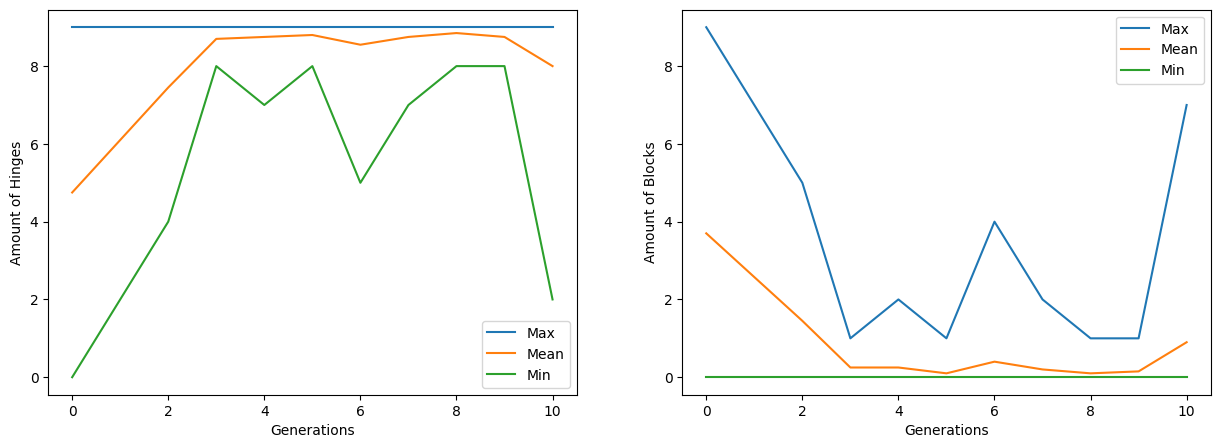

In [4]:
# calculate max min avg
hngs = (
    df[["generation_index", "hinges"]]
    .groupby(by="generation_index")
    .describe()["hinges"]
)

blcks = (
    df[["generation_index", "blocks"]]
    .groupby(by="generation_index")
    .describe()["blocks"]
)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.set_xlabel("Generations")
ax1.set_ylabel("Amount of Hinges")
ax1.plot(hngs[["max", "mean", "min"]], label= ["Max", "Mean", "Min"])
ax1.legend()

ax2.set_xlabel("Generations")
ax2.set_ylabel("Amount of Blocks")
ax2.plot(blcks[["max","mean","min"]], label= ["Max", "Mean", "Min"])
ax2.legend()

## Sandbox: Novelty Metric

In [5]:
tests = ['yates-chi-squared', 'chi-squared', 'hellinger-dist', 'manhattan-dist', 'euclidian-dist', 'chybyshev_distance', 'pcc']

In [9]:
generation_groups = df[["generation_index", "serialized_multineat_genome"]].groupby(by="generation_index")
genome_groups = [data["serialized_multineat_genome"].values for _, data in generation_groups]


for test in tests:
    print(f"\n Test: {test}")
    novelty_scores = pf.get_novelty_population(genome_groups[2], normalization="clipping", test=test)
    print(novelty_scores)


 Test: yates-chi-squared
[305643910.5080148, 305626552.40222675, 305668910.6795117, 305483733.7862792, 305320503.1312274, 305747044.02868253, 305404994.49187315, 305598407.12897384, 305790767.43116164, 305392548.45348275, 305809490.66214377, 305373825.2225006, 305373825.2225006, 305373825.2225006, 305061021.60386455, 305045610.91962445, 305945400.59799993, 305156314.5369546, 305411953.76582813, 305411953.76582813]

 Test: chi-squared


/home/oliver/Thesis/analysis/phenotype_framework.py:183: RuntimeWarning: invalid value encountered in divide
  norm = lambda x: (x - min_val) / (max_val - min_val)


[427.58074226642674, 1638992.376063375, 100428.10167888895, 110028.37883497945, 1552669.9223085628, 209832.37454859415, 284271.9530387939, 1256295.7442332879, 317733.7261990687, 368470.85310669953, 325634.5569129208, 360570.02239284746, 360570.02239284746, 360570.02239284746, 715004.1403614313, 721069.7244404403, 572238.4929441258, 977477.0061759942, 502383.40095704794, 502383.40095704794]

 Test: hellinger-dist
[1.1531176398308676, 2.117289665979025, 1.1531176398308676, 1.0262154565273627, 2.0018330282230226, 1.1531176398308676, 0.9772138911001443, 2.117289665979025, 1.1531176398308676, 0.9772138911001443, 1.1531176398308676, 0.9772138911001443, 0.9772138911001443, 0.9772138911001443, 2.1182810489623307, 2.0018330282230226, 1.1531176398308676, 1.4943697046878817, 0.9772138911001443, 0.9772138911001443]

 Test: manhattan-dist
[1.9167784460441677, 3.2764383667408574, 1.9167784460441677, 1.7592578253915903, 3.2146760798464307, 1.9167784460441677, 1.6552066369214906, 3.2764383667408574, 1